In [31]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libraries
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import joblib

In [38]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

print("Starting Modeling Pipeline\n")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Class Balance (Train): {y_train.value_counts(normalize=True).round(3)}")

Starting Modeling Pipeline

Train: (491, 20), Test: (123, 20)
Class Balance (Train): Loan_Status
1              0.686
0              0.314
Name: proportion, dtype: float64


### Baseline Models

In [40]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

print("BASELINE MODEL PERFORMANCE (Test Set)")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    results[name] = {'accuracy': acc, 'auc': auc}
    
    print(f"\n{name}")
    print(f"Accuracy : {acc:.4f}")
    if auc:
        print(f"ROC-AUC  : {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))

BASELINE MODEL PERFORMANCE (Test Set)

Logistic Regression
Accuracy : 0.8618
ROC-AUC  : 0.8198
Classification Report:
              precision    recall  f1-score   support

           0      0.957     0.579     0.721        38
           1      0.840     0.988     0.908        85

    accuracy                          0.862       123
   macro avg      0.898     0.784     0.815       123
weighted avg      0.876     0.862     0.850       123


Random Forest
Accuracy : 0.8699
ROC-AUC  : 0.8647
Classification Report:
              precision    recall  f1-score   support

           0      0.806     0.763     0.784        38
           1      0.897     0.918     0.907        85

    accuracy                          0.870       123
   macro avg      0.851     0.840     0.845       123
weighted avg      0.868     0.870     0.869       123


XGBoost
Accuracy : 0.8374
ROC-AUC  : 0.8238
Classification Report:
              precision    recall  f1-score   support

           0      0.737     0.7

### Hyperparameter Tuning

In [36]:
print("HYPERPARAMETER TUNING")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")

HYPERPARAMETER TUNING
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Parameters: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best CV F1 Score: 0.8706


### Model Evaluation

In [35]:
y_pred_tuned = best_rf.predict(X_test)
y_proba_tuned = best_rf.predict_proba(X_test)[:, 1]

final_acc = accuracy_score(y_test, y_pred_tuned)
final_auc = roc_auc_score(y_test, y_proba_tuned)
final_f1 = classification_report(y_test, y_pred_tuned, output_dict=True)['weighted avg']['f1-score']


print("FINAL MODEL: TUNED RANDOM FOREST")
print(f"Accuracy : {final_acc:.4f}")
print(f"ROC-AUC  : {final_auc:.4f}")
print(f"F1-Score : {final_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, digits=3))

FINAL MODEL: TUNED RANDOM FOREST
Accuracy : 0.8780
ROC-AUC  : 0.8576
F1-Score : 0.8743

Classification Report:
              precision    recall  f1-score   support

           0      0.871     0.711     0.783        38
           1      0.880     0.953     0.915        85

    accuracy                          0.878       123
   macro avg      0.876     0.832     0.849       123
weighted avg      0.878     0.878     0.874       123



### Confusion Matrix

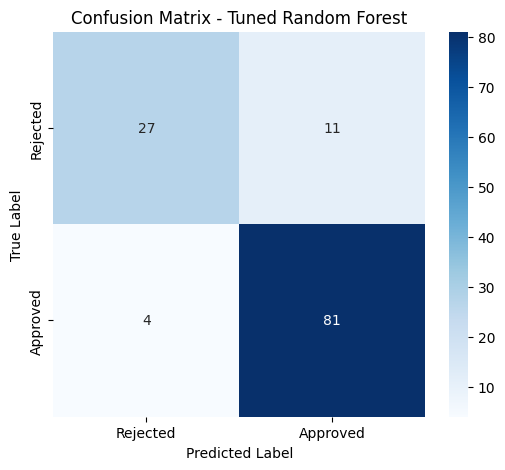

In [25]:
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rejected', 'Approved'], 
            yticklabels=['Rejected', 'Approved'])
plt.title('Confusion Matrix - Tuned Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC Curve

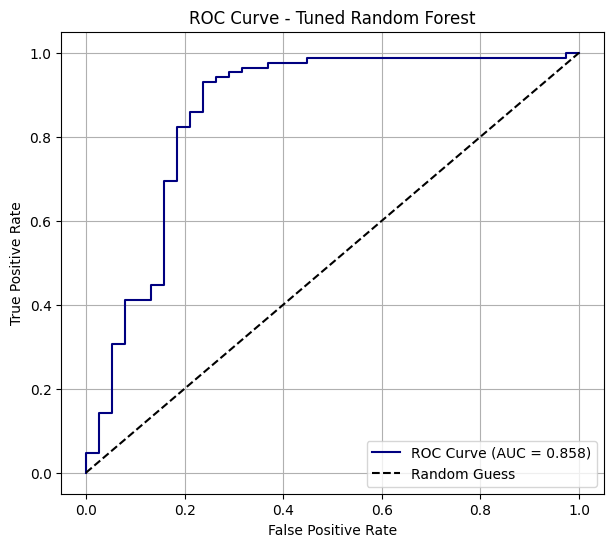

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_proba_tuned)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {final_auc:.3f})', color='navy')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Random Forest')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance

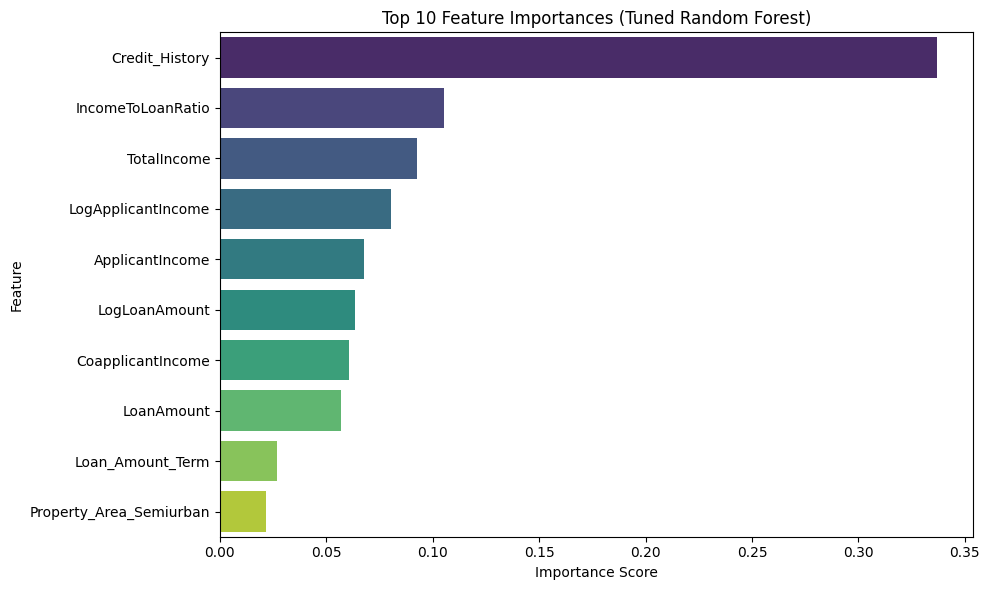


Top 5 Predictive Features:
           Feature  Importance
    Credit_History    0.336776
 IncomeToLoanRatio    0.105178
       TotalIncome    0.092423
LogApplicantIncome    0.080482
   ApplicantIncome    0.067745


In [27]:
importances = best_rf.feature_importances_
feature_names = X_train.columns
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Top 10 Feature Importances (Tuned Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("\nTop 5 Predictive Features:")
print(feat_imp.head(5).to_string(index=False))

### Cross-Validation Stability

In [41]:
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-Validation F1 Scores: {cv_scores.round(4)}")
print(f"Mean CV F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-Validation F1 Scores: [0.8667 0.8591 0.8904 0.8684 0.8684]
Mean CV F1: 0.8706 ± 0.0105


In [45]:
# # Save Final Model & Scaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# joblib.dump(best_rf, 'final_loan_approval_model.pkl')
# joblib.dump(scaler, 'scaler.pkl')  
# print("\nModel and scaler saved: 'final_loan_approval_model.pkl', 'scaler.pkl'")

# # scaler = joblib.load("scaler.pkl")
# # scaler.transform(X_test)

### Prediction Function

In [42]:
def predict_loan_status(new_data_df):
    """
    Predict loan approval for new applicant(s)
    new_data_df: DataFrame with same raw columns as original
    """
    # Apply same preprocessing steps (simplified)
    # (In production: use ColumnTransformer + Pipeline)
    # For demo: assume preprocessing function exists
    print("Use saved pipeline in production. Demo only.")
    return best_rf.predict(new_data_df), best_rf.predict_proba(new_data_df)[:, 1]


print("MODEL TRAINING COMPLETE!")
print(f"Best Model: Tuned Random Forest | F1: {final_f1:.3f} | AUC: {final_auc:.3f}")


MODEL TRAINING COMPLETE!
Best Model: Tuned Random Forest | F1: 0.874 | AUC: 0.858
